### Random forest classification on data from sliding window

Aim is to use a sliding window to calculate features. The window length might act a bit like a filter

In [1]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
%matplotlib inline

In [9]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [12]:
feature_files = glob.glob('/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict/rms_sliding_10/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[-1].split('.')[0][:-18]
    print(fname)
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

skewness
minimum
maximum
abs_energy
cid_ce
median
x_crossing_m
variance
interquartile_range
mean_change
root_mean_square
mean
mean_abs_change
kurtosis


In [13]:
feature_dfs[0].head()

,channel_75,channel_76,channel_77,channel_78,channel_79,channel_80,channel_81,channel_82,channel_83,channel_84,...,channel_86,channel_87,channel_88,channel_89,channel_90,channel_91,channel_92,channel_93,channel_94,time
0,-0.269375,-0.256548,-0.151903,0.069723,0.141415,0.169870,0.124374,-0.096271,-0.124580,-0.294946,...,-0.081089,-0.045847,-0.343732,-0.241530,-0.046841,0.226312,0.239830,0.357177,0.182656,2016-08-05T18:12:38.969414Z
1,-0.036099,-0.109032,-0.057988,0.116761,0.037290,0.079942,0.025367,-0.094667,0.028545,-0.023225,...,-0.080795,-0.059955,-0.336017,-0.257605,0.041217,0.232311,0.241358,0.293522,0.250899,2016-08-05T18:17:38.969779Z
2,-0.609823,-0.267885,-0.284022,-0.169787,-0.141827,-0.108281,-0.393403,-0.097614,-0.153862,-0.157018,...,-0.432070,-0.767684,-0.745247,-0.385655,0.238561,0.136256,0.090512,0.188097,0.374976,2016-08-05T18:22:38.969779Z
3,-0.819602,-0.355962,-0.378902,-0.345712,0.105413,-0.074047,-0.498908,-0.081797,NaN,NaN,...,NaN,NaN,NaN,-0.505557,NaN,-0.030877,0.039957,0.345046,0.193354,2016-08-05T18:27:38.969779Z
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T19:03:01.282279Z


In [14]:
lineCSN_M3.head()

,file_name,M3_20_Avg_interp,Temphigh_interp
DateTime,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156


We need to generate an interpolation function first, so we can interpolate the soil moisture and temperature values to the time column in each of the feature dataframes

In [15]:
lineCSN_M3['TTime'] = lineCSN_M3.index

In [16]:
stime = lineCSN_M3.index[0]
print(op.UTCDateTime(stime))

2016-08-05T18:07:38.000000Z


In [17]:
lineCSN_M3 = lineCSN_M3.assign(tsince_start=lineCSN_M3['TTime'].apply(lambda x: op.UTCDateTime(x) - op.UTCDateTime(stime)))

In [18]:
lineCSN_M3.head(7)

,file_name,M3_20_Avg_interp,Temphigh_interp,TTime,tsince_start
DateTime,,,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489,2016-08-05 18:07:38,0.0
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656,2016-08-05 18:08:38,60.0
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822,2016-08-05 18:09:38,120.0
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989,2016-08-05 18:10:38,180.0
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156,2016-08-05 18:11:38,240.0
2016-08-05 18:12:38,20160805181238_40_Hz_LineCSN.mseed,0.202313,27.368322,2016-08-05 18:12:38,300.0
2016-08-05 18:13:38,20160805181338_40_Hz_LineCSN.mseed,0.202413,27.354489,2016-08-05 18:13:38,360.0


In [19]:
f_soilM = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['M3_20_Avg_interp'].values)

In [20]:
f_temp = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['Temphigh_interp'].values)

In [80]:
channels_to_drop = ['time','channel_75','channel_76','channel_77','channel_78','channel_79','channel_90',
                   'channel_91','channel_92','channel_93','channel_94']
channels_to_drop = ['time']

def extract_mean_over_channels(indf):
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['time']]
    opdf = opdf.assign(mean_col = indf.drop(channels_to_drop,axis=1).mean(axis=1))
    opdf.columns = ['time',newcolname]
    
    return opdf

In [81]:
indf = extract_mean_over_channels(feature_dfs[0])

In [82]:
indf.head()

,time,mean_skewness
0,2016-08-05T18:12:38.969414Z,-0.028533
1,2016-08-05T18:17:38.969779Z,0.010846
2,2016-08-05T18:22:38.969779Z,-0.210072
3,2016-08-05T18:27:38.969779Z,-0.185200
4,2016-08-05T19:03:01.282279Z,NaN


In [83]:
for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df

In [84]:
merged_df.head()

,time,mean_skewness,mean_minimum,mean_maximum,mean_abs_energy,mean_cid_ce,mean_median,mean_x_crossing_m,mean_variance,mean_interquartile_range,mean_mean_change,mean_root_mean_square,mean_mean,mean_mean_abs_change,mean_kurtosis
0,2016-08-05T18:12:38.969414Z,-0.028533,-614.650394,677.723929,3.549637e+07,8245.104204,-0.210091,12465.150000,1478.912574,17.885254,-0.000047,38.008812,-0.277244,27.096341,46.098760
1,2016-08-05T18:17:38.969779Z,0.010846,-663.605323,703.095324,3.829154e+07,8493.125831,-0.218435,12309.650000,1595.404642,18.936258,-0.000202,39.491262,-0.261959,27.739620,50.212988
2,2016-08-05T18:22:38.969779Z,-0.210072,-682.698426,622.789212,2.680343e+07,7455.428461,-0.242036,12570.400000,1116.702617,17.644778,0.000174,32.870414,-0.293362,25.171494,62.586067
3,2016-08-05T18:27:38.969779Z,-0.185200,-521.258771,455.539861,1.749924e+07,6082.305022,-0.359450,12515.923077,728.947431,13.898409,-0.000015,26.673438,-0.388563,20.734640,40.252782
4,2016-08-05T19:03:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))

In [86]:
merged_df.head()

,time,mean_skewness,mean_minimum,mean_maximum,mean_abs_energy,mean_cid_ce,mean_median,mean_x_crossing_m,mean_variance,mean_interquartile_range,mean_mean_change,mean_root_mean_square,mean_mean,mean_mean_abs_change,mean_kurtosis,tsince_start
0,2016-08-05T18:12:38.969414Z,-0.028533,-614.650394,677.723929,3.549637e+07,8245.104204,-0.210091,12465.150000,1478.912574,17.885254,-0.000047,38.008812,-0.277244,27.096341,46.098760,300.969414
1,2016-08-05T18:17:38.969779Z,0.010846,-663.605323,703.095324,3.829154e+07,8493.125831,-0.218435,12309.650000,1595.404642,18.936258,-0.000202,39.491262,-0.261959,27.739620,50.212988,600.969779
2,2016-08-05T18:22:38.969779Z,-0.210072,-682.698426,622.789212,2.680343e+07,7455.428461,-0.242036,12570.400000,1116.702617,17.644778,0.000174,32.870414,-0.293362,25.171494,62.586067,900.969779
3,2016-08-05T18:27:38.969779Z,-0.185200,-521.258771,455.539861,1.749924e+07,6082.305022,-0.359450,12515.923077,728.947431,13.898409,-0.000015,26.673438,-0.388563,20.734640,40.252782,1200.969779
4,2016-08-05T19:03:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3323.282279


In [87]:
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [88]:
merged_df.head()

,time,mean_skewness,mean_minimum,mean_maximum,mean_abs_energy,mean_cid_ce,mean_median,mean_x_crossing_m,mean_variance,mean_interquartile_range,mean_mean_change,mean_root_mean_square,mean_mean,mean_mean_abs_change,mean_kurtosis,tsince_start,M3_20_Avg_interp,Temphigh_interp
0,2016-08-05T18:12:38.969414Z,-0.028533,-614.650394,677.723929,3.549637e+07,8245.104204,-0.210091,12465.150000,1478.912574,17.885254,-0.000047,38.008812,-0.277244,27.096341,46.098760,300.969414,0.202315,27.368099
1,2016-08-05T18:17:38.969779Z,0.010846,-663.605323,703.095324,3.829154e+07,8493.125831,-0.218435,12309.650000,1595.404642,18.936258,-0.000202,39.491262,-0.261959,27.739620,50.212988,600.969779,0.202815,27.298932
2,2016-08-05T18:22:38.969779Z,-0.210072,-682.698426,622.789212,2.680343e+07,7455.428461,-0.242036,12570.400000,1116.702617,17.644778,0.000174,32.870414,-0.293362,25.171494,62.586067,900.969779,0.202685,27.229765
3,2016-08-05T18:27:38.969779Z,-0.185200,-521.258771,455.539861,1.749924e+07,6082.305022,-0.359450,12515.923077,728.947431,13.898409,-0.000015,26.673438,-0.388563,20.734640,40.252782,1200.969779,0.202185,27.160599
4,2016-08-05T19:03:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3323.282279,0.202000,26.158960


In [89]:
cleaned_df = merged_df.dropna()

In [90]:
cleaned_df.head(10)

,time,mean_skewness,mean_minimum,mean_maximum,mean_abs_energy,mean_cid_ce,mean_median,mean_x_crossing_m,mean_variance,mean_interquartile_range,mean_mean_change,mean_root_mean_square,mean_mean,mean_mean_abs_change,mean_kurtosis,tsince_start,M3_20_Avg_interp,Temphigh_interp
0,2016-08-05T18:12:38.969414Z,-0.028533,-614.650394,677.723929,3.549637e+07,8245.104204,-0.210091,12465.150000,1478.912574,17.885254,-0.000047,38.008812,-0.277244,27.096341,46.098760,300.969414,0.202315,27.368099
1,2016-08-05T18:17:38.969779Z,0.010846,-663.605323,703.095324,3.829154e+07,8493.125831,-0.218435,12309.650000,1595.404642,18.936258,-0.000202,39.491262,-0.261959,27.739620,50.212988,600.969779,0.202815,27.298932
2,2016-08-05T18:22:38.969779Z,-0.210072,-682.698426,622.789212,2.680343e+07,7455.428461,-0.242036,12570.400000,1116.702617,17.644778,0.000174,32.870414,-0.293362,25.171494,62.586067,900.969779,0.202685,27.229765
3,2016-08-05T18:27:38.969779Z,-0.185200,-521.258771,455.539861,1.749924e+07,6082.305022,-0.359450,12515.923077,728.947431,13.898409,-0.000015,26.673438,-0.388563,20.734640,40.252782,1200.969779,0.202185,27.160599
6,2016-08-05T19:43:23.598811Z,-0.013476,-271.111517,276.919128,2.100399e+07,6857.302135,-0.557008,12265.050000,874.828803,21.100299,0.000348,29.440751,-0.563170,26.866278,9.639218,5745.598811,0.202000,24.796010
7,2016-08-05T19:48:23.598811Z,-0.007792,-280.429809,308.135023,2.945192e+07,8134.505695,-0.569386,12425.150000,1226.792112,28.080901,-0.000171,34.799422,-0.589465,33.797160,6.443161,6045.598811,0.202000,24.576843
8,2016-08-05T19:53:23.598811Z,-0.040136,-320.910078,333.859269,3.140838e+07,8525.055047,-0.528508,12686.600000,1308.230364,32.008862,0.000252,35.796593,-0.616826,36.437691,6.540906,6345.598811,0.201611,24.357676
9,2016-08-05T19:58:23.598811Z,-0.160891,-709.042281,620.679876,2.934539e+07,8459.125414,-0.612073,12769.900000,1222.165346,26.174337,0.000419,34.613211,-0.650330,32.804763,30.478672,6645.598811,0.201111,24.138510
10,2016-08-05T20:03:23.598811Z,-0.117534,-709.042281,620.679876,2.363327e+07,7438.195833,-0.669291,12592.950000,984.234357,21.526760,0.000127,31.063217,-0.660311,27.712539,44.198772,6945.598811,0.201000,23.989423
11,2016-08-05T20:08:23.598811Z,0.108879,-373.885270,381.809902,2.648225e+07,7655.152280,-0.656384,12495.000000,1103.056486,23.136270,0.000255,32.830687,-0.585056,29.812009,13.696726,7245.598811,0.201000,23.860256


Training on unfilted timeseries

In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

In [92]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=800,min_samples_leaf=10,oob_score=True,n_jobs=2)

In [94]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [76]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.06966305 0.07804305 0.05751667 0.01605771 0.0504194  0.12652258
 0.15967383 0.01639524 0.08934588 0.05755217 0.02487226 0.12951569
 0.05872888 0.06569358]
0.14832882768221134


In [77]:
regr.score(X_test,y_test)

0.13478115921721512

In [78]:
regr_pred = regr.predict(X_test)

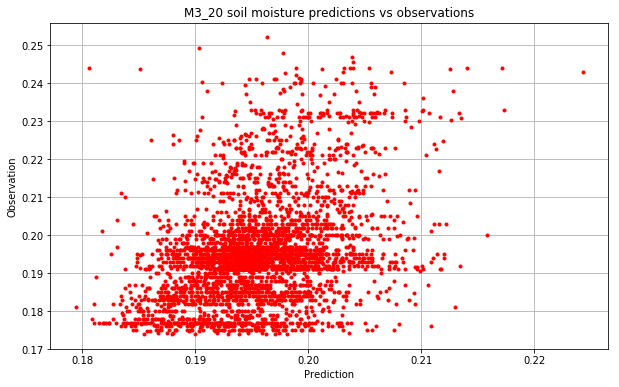

In [79]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

What about the temperature timeseries?

In [52]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=600,min_samples_leaf=10,oob_score=True,n_jobs=2)

In [54]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [55]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.04822139 0.04500825 0.04779209 0.01093278 0.02799577 0.15468363
 0.28243397 0.01096232 0.06672457 0.04009574 0.01678879 0.10617198
 0.03761352 0.10457519]
0.3117839429438667


In [56]:
regr.score(X_test,y_test)

0.34692305472981155

In [57]:
regr_pred = regr.predict(X_test)

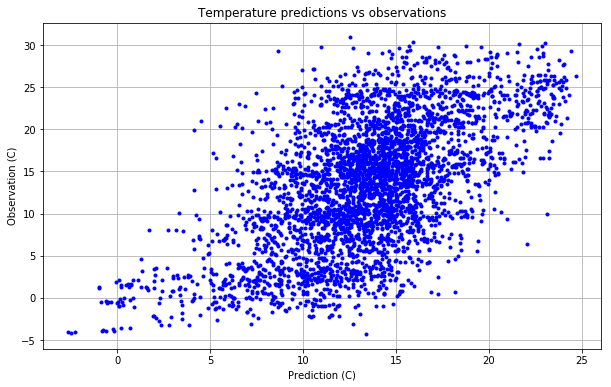

In [58]:
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.xlabel('Prediction (C)')
plt.ylabel('Observation (C)')
plt.grid()
plt.savefig('temperature_prediction_sliding_window.png')

In [182]:
from scipy.signal import butter, lfilter

In [183]:
def butter_lowpass(cutoff,fs,order=4):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order,normal_cutoff,btype='low')
    return b,a

def butter_lowpass_filter(data,cutoff,fs,order=4):
    b,a = butter_lowpass(cutoff,fs,order=order)
    y = lfilter(b,a,data)
    return y


In [184]:
fs = 0.00333 #sampling every minute
cutoff = 0.0001 #we want to smooth the ts (say one hour smoothing - seems to much for the soil moisture)

In [185]:
filtered_df = pd.DataFrame()
filtered_df['time'] = cleaned_df['time']
filtered_df['M3_20_Avg_interp'] = cleaned_df['M3_20_Avg_interp']
filtered_df['Temphigh_interp'] = cleaned_df['Temphigh_interp']

for column in cleaned_df.columns[1:-3]:
    cname = str(column)
    print(cname)
    filtered_df[cname] = butter_lowpass_filter(cleaned_df[cname].values,cutoff,fs)

mean_skewness
mean_minimum
mean_maximum
mean_abs_energy
mean_cid_ce
mean_median
mean_x_crossing_m
mean_variance
mean_interquartile_range
mean_mean_change
mean_root_mean_square
mean_mean
mean_mean_abs_change
mean_kurtosis


In [186]:
y = filtered_df['M3_20_Avg_interp']
X = filtered_df.drop(['time','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [187]:
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [188]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [189]:
print(regr.feature_importances_)

[0.10230375 0.06978214 0.05915511 0.02104785 0.0387498  0.08808819
 0.15616654 0.02198886 0.08025563 0.10866015 0.02432584 0.09424435
 0.04020933 0.09502246]


In [190]:
print(regr.oob_score_) 

0.7639397877613935


In [191]:
regr_pred = regr.predict(X_test)

In [192]:
regr.score(X_test,y_test)

0.7738241618505284

Text(0,0.5,'Actual')

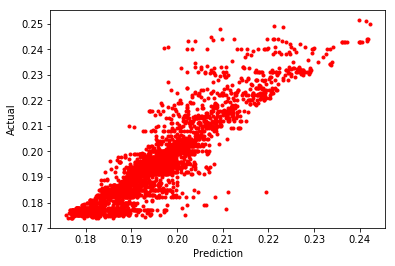

In [193]:
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Actual')